In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required libraries.

In [31]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import argparse
import os, datetime
import matplotlib.pyplot as plt
from scipy.io import loadmat

from keras import Sequential

from tensorflow.python.keras.layers import AveragePooling2D, Dropout,Flatten, Dense
from tensorflow.keras.applications import  resnet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

Declaring the image size accoring to the imagenet specifications and the paths to the train/test/validation splits.

In [3]:
image_size = [224, 224]

train = '/content/drive/MyDrive/102flowers/jpg/train'
test = '/content/drive/MyDrive/102flowers/jpg/test'
valid = '/content/drive/MyDrive/102flowers/jpg/valid'


### Loading the Data

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    test,
    image_size=(224, 224),
    shuffle = True,
    batch_size = 32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    train,
    image_size=(224, 224),
    shuffle = False,
    batch_size = 32,

)

val_data = tf.keras.utils.image_dataset_from_directory(
    valid,
    image_size=(224, 224),
    shuffle = False,
    batch_size = 32
)

Found 6149 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.


In [5]:
print(train_data.class_names)
print("Number of classes in train set ", len(train_data.class_names))

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Number of classes in train set  102


Plotting some example data from the training set.

In [6]:
all_labels = []
for data in train_data.take(-1):
    labels = data[1]
    all_labels.append(np.array(labels))

def get_counts(all_labels):
    dicto = {}
    for num in range(0, 102):
        dicto[str(num)] = 0
        for i in range(len(all_labels)):
            for j in range(len(all_labels[i])):
                if num == all_labels[i][j]:
                    dicto[str(num)] += 1
    return dicto

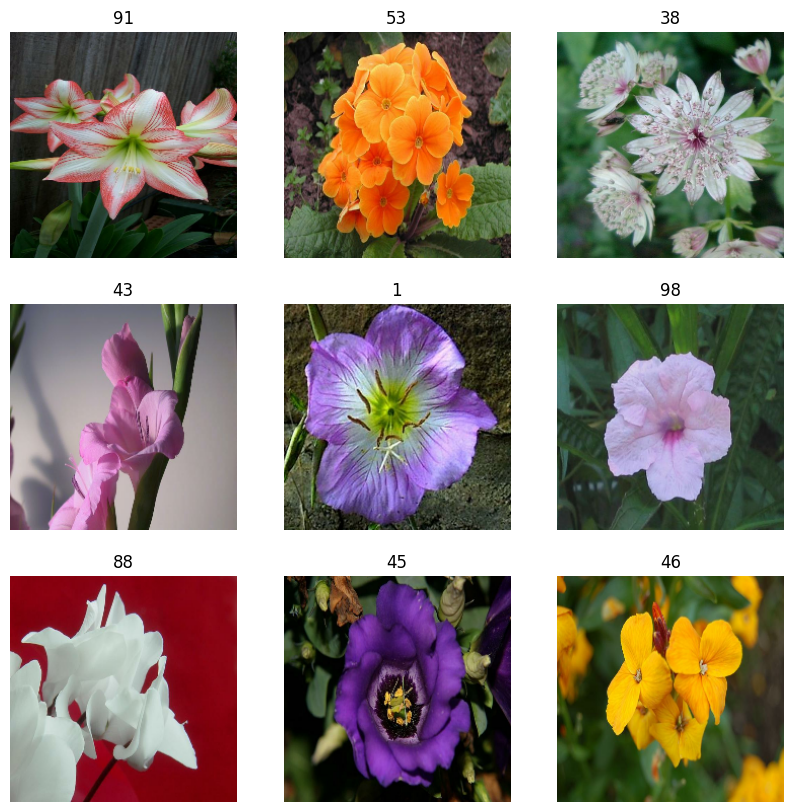

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")


### Defining the NN structure


First, we initialize the ResNet50V2 model pretrained with image net weights. We skip the last layer of the model because we will add more layers on top of it. The input size is set to (224, 224, 3) based on imagenet specifications. Furthermore, we freeze the train parameter of the resnet layers to avoid retraining them all over again.

In [8]:
resnet = tf.keras.applications.ResNet50V2(include_top = False,
                                          weights = "imagenet",
                                          pooling = 'avg',
                                          classes = 102,
                                          input_shape=image_size + [3])
for layer in resnet.layers:
  layer.trainable = False


Adding Callbacks : ReduceLROnPlateau: Reduces the learning rate whenever the metric being monitored plateaus. Here, the train accuracy is being monitored for plateau.
ModelCheckpoint: This saves the model whenever the metric being monitored improves in the next epoch.

In [30]:
logdir = os.path.join("/content/drive/MyDrive/102flowers/logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1,
                              patience=3, verbose=1, cooldown=3, mode='auto', min_delta=0.01)

checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath='/outp3',
    monitor='accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)

Adding augmentations to the train data. The input images undergo the following augmentations:
RandomFlips: Horizontal and Vertical
RandomRotations: Random rotations upto a factor of 0.4
Rescaling: We normalize the images here by converting their pixel values to a range between 0-1 by dividing them by 255

In [33]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255)

])


Adding custom layers on top of the pre-trained resnet model.

In [12]:
from keras.regularizers import L1L2
model = Sequential([
    data_augmentation,

    resnet,
    tf.keras.layers.Flatten(),

    #tf.keras.layers.Dense(1024, activation='relu', bias_regularizer = L1L2(l1=0.01, l2=0.02)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu',bias_regularizer = L1L2(l1=0.01, l2=0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu', bias_regularizer = L1L2(l1=0.01, l2= 0.02)),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(64, activation = 'relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(102, activation = 'softmax')
]
)
model.build(input_shape = (None, 224, 224, 3))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

The model is compiled using the Adam optimizer function. The learning rate is set to 7e-4. The loss function is sparse_categorical_crossentropy.

In [14]:
#from keras.optimizers import SGD
##opt = SGD(learning_rate=0.0001)
#model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ['accuracy'])
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
  metrics=['accuracy']
)

Plotting the model architecture.

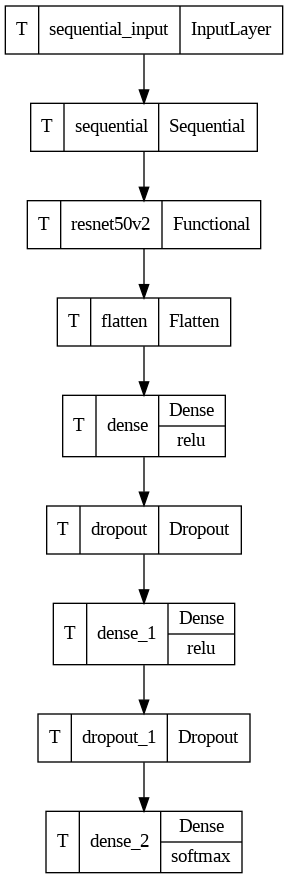

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)


### Training the model.

The final trained model demonstrates an accuracy of ~91% on the train set and ~88% on the validation set after 45 epochs.

In [15]:
#tf.get_logger().setLevel('INFO')
#tf.keras.backend.set_learning_phase(1)
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=45,
  callbacks=[reduce_lr,checkpoint]

)

Epoch 1/45
193/193 [==============================] - ETA: 0s - loss: 3.4472 - accuracy: 0.2391
Epoch 1: accuracy improved from -inf to 0.23906, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 53s 239ms/step - loss: 3.4472 - accuracy: 0.2391 - val_loss: 2.4070 - val_accuracy: 0.4402 - lr: 7.0000e-04
Epoch 2/45
192/193 [============================>.] - ETA: 0s - loss: 2.0868 - accuracy: 0.4736
Epoch 2: accuracy improved from 0.23906 to 0.47374, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 44s 227ms/step - loss: 2.0863 - accuracy: 0.4737 - val_loss: 1.5586 - val_accuracy: 0.5794 - lr: 7.0000e-04
Epoch 3/45
193/193 [==============================] - ETA: 0s - loss: 1.5738 - accuracy: 0.5796
Epoch 3: accuracy improved from 0.47374 to 0.57961, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 232ms/step - loss: 1.5738 - accuracy: 0.5796 - val_loss: 1.2381 - val_accuracy: 0.6490 - lr: 7.0000e-04
Epoch 4/45
193/193 [==============================] - ETA: 0s - loss: 1.3301 - accuracy: 0.6372
Epoch 4: accuracy improved from 0.57961 to 0.63718, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 230ms/step - loss: 1.3301 - accuracy: 0.6372 - val_loss: 1.0770 - val_accuracy: 0.6980 - lr: 7.0000e-04
Epoch 5/45
192/193 [============================>.] - ETA: 0s - loss: 1.1386 - accuracy: 0.6825
Epoch 5: accuracy improved from 0.63718 to 0.68255, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 234ms/step - loss: 1.1384 - accuracy: 0.6826 - val_loss: 0.9253 - val_accuracy: 0.7363 - lr: 7.0000e-04
Epoch 6/45
192/193 [============================>.] - ETA: 0s - loss: 1.0150 - accuracy: 0.7101
Epoch 6: accuracy improved from 0.68255 to 0.71020, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 231ms/step - loss: 1.0149 - accuracy: 0.7102 - val_loss: 0.8284 - val_accuracy: 0.7569 - lr: 7.0000e-04
Epoch 7/45
192/193 [============================>.] - ETA: 0s - loss: 0.9416 - accuracy: 0.7368
Epoch 7: accuracy improved from 0.71020 to 0.73687, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 236ms/step - loss: 0.9416 - accuracy: 0.7369 - val_loss: 0.7737 - val_accuracy: 0.7971 - lr: 7.0000e-04
Epoch 8/45
192/193 [============================>.] - ETA: 0s - loss: 0.8701 - accuracy: 0.7550
Epoch 8: accuracy improved from 0.73687 to 0.75508, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 236ms/step - loss: 0.8703 - accuracy: 0.7551 - val_loss: 0.7136 - val_accuracy: 0.7843 - lr: 7.0000e-04
Epoch 9/45
192/193 [============================>.] - ETA: 0s - loss: 0.8230 - accuracy: 0.7612
Epoch 9: accuracy improved from 0.75508 to 0.76126, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 236ms/step - loss: 0.8244 - accuracy: 0.7613 - val_loss: 0.7248 - val_accuracy: 0.8010 - lr: 7.0000e-04
Epoch 10/45
192/193 [============================>.] - ETA: 0s - loss: 0.7725 - accuracy: 0.7769
Epoch 10: accuracy improved from 0.76126 to 0.77687, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 231ms/step - loss: 0.7724 - accuracy: 0.7769 - val_loss: 0.6871 - val_accuracy: 0.8039 - lr: 7.0000e-04
Epoch 11/45
192/193 [============================>.] - ETA: 0s - loss: 0.7550 - accuracy: 0.7788
Epoch 11: accuracy improved from 0.77687 to 0.77899, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 235ms/step - loss: 0.7545 - accuracy: 0.7790 - val_loss: 0.6518 - val_accuracy: 0.8108 - lr: 7.0000e-04
Epoch 12/45
192/193 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.8105
Epoch 12: accuracy improved from 0.77899 to 0.81070, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 237ms/step - loss: 0.6758 - accuracy: 0.8107 - val_loss: 0.6313 - val_accuracy: 0.8137 - lr: 7.0000e-04
Epoch 13/45
192/193 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.8099
Epoch 13: accuracy did not improve from 0.81070
193/193 [==============================] - 21s 108ms/step - loss: 0.6639 - accuracy: 0.8101 - val_loss: 0.6380 - val_accuracy: 0.8157 - lr: 7.0000e-04
Epoch 14/45
192/193 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.8153
Epoch 14: accuracy improved from 0.81070 to 0.81542, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 48s 247ms/step - loss: 0.6428 - accuracy: 0.8154 - val_loss: 0.5909 - val_accuracy: 0.8294 - lr: 7.0000e-04
Epoch 15/45
192/193 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.8276
Epoch 15: accuracy improved from 0.81542 to 0.82745, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 236ms/step - loss: 0.6007 - accuracy: 0.8275 - val_loss: 0.6179 - val_accuracy: 0.8265 - lr: 7.0000e-04
Epoch 16/45
193/193 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.8244
Epoch 16: accuracy did not improve from 0.82745
193/193 [==============================] - 22s 111ms/step - loss: 0.5930 - accuracy: 0.8244 - val_loss: 0.5611 - val_accuracy: 0.8412 - lr: 7.0000e-04
Epoch 17/45
193/193 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.8366
Epoch 17: accuracy improved from 0.82745 to 0.83656, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 47s 245ms/step - loss: 0.5529 - accuracy: 0.8366 - val_loss: 0.5782 - val_accuracy: 0.8422 - lr: 7.0000e-04
Epoch 18/45
192/193 [============================>.] - ETA: 0s - loss: 0.5452 - accuracy: 0.8415
Epoch 18: accuracy improved from 0.83656 to 0.84144, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 233ms/step - loss: 0.5450 - accuracy: 0.8414 - val_loss: 0.5974 - val_accuracy: 0.8343 - lr: 7.0000e-04
Epoch 19/45
193/193 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.8440
Epoch 19: accuracy improved from 0.84144 to 0.84404, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 235ms/step - loss: 0.5249 - accuracy: 0.8440 - val_loss: 0.5724 - val_accuracy: 0.8333 - lr: 7.0000e-04
Epoch 20/45
192/193 [============================>.] - ETA: 0s - loss: 0.5196 - accuracy: 0.8475
Epoch 20: accuracy improved from 0.84404 to 0.84745, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 232ms/step - loss: 0.5197 - accuracy: 0.8475 - val_loss: 0.5822 - val_accuracy: 0.8373 - lr: 7.0000e-04
Epoch 21/45
192/193 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.8434
Epoch 21: ReduceLROnPlateau reducing learning rate to 6.99999975040555e-05.

Epoch 21: accuracy did not improve from 0.84745
193/193 [==============================] - 21s 109ms/step - loss: 0.5213 - accuracy: 0.8434 - val_loss: 0.5190 - val_accuracy: 0.8627 - lr: 7.0000e-04
Epoch 22/45
192/193 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.8743
Epoch 22: accuracy improved from 0.84745 to 0.87445, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 237ms/step - loss: 0.4168 - accuracy: 0.8745 - val_loss: 0.4684 - val_accuracy: 0.8716 - lr: 7.0000e-05
Epoch 23/45
193/193 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8876
Epoch 23: accuracy improved from 0.87445 to 0.88762, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 234ms/step - loss: 0.3762 - accuracy: 0.8876 - val_loss: 0.4551 - val_accuracy: 0.8745 - lr: 7.0000e-05
Epoch 24/45
192/193 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8919
Epoch 24: accuracy improved from 0.88762 to 0.89201, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 47s 241ms/step - loss: 0.3697 - accuracy: 0.8920 - val_loss: 0.4570 - val_accuracy: 0.8745 - lr: 7.0000e-05
Epoch 25/45
192/193 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.8940
Epoch 25: accuracy improved from 0.89201 to 0.89413, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 234ms/step - loss: 0.3468 - accuracy: 0.8941 - val_loss: 0.4462 - val_accuracy: 0.8725 - lr: 7.0000e-05
Epoch 26/45
193/193 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8943
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.999999459367246e-06.

Epoch 26: accuracy improved from 0.89413 to 0.89429, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 237ms/step - loss: 0.3533 - accuracy: 0.8943 - val_loss: 0.4467 - val_accuracy: 0.8745 - lr: 7.0000e-05
Epoch 27/45
192/193 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.9058
Epoch 27: accuracy improved from 0.89429 to 0.90584, saving model to /outp3


INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 45s 234ms/step - loss: 0.3208 - accuracy: 0.9058 - val_loss: 0.4469 - val_accuracy: 0.8745 - lr: 7.0000e-06
Epoch 28/45
193/193 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8990
Epoch 28: accuracy did not improve from 0.90584
193/193 [==============================] - 21s 109ms/step - loss: 0.3386 - accuracy: 0.8990 - val_loss: 0.4475 - val_accuracy: 0.8765 - lr: 7.0000e-06
Epoch 29/45
192/193 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.9058
Epoch 29: accuracy did not improve from 0.90584
193/193 [==============================] - 22s 110ms/step - loss: 0.3171 - accuracy: 0.9054 - val_loss: 0.4476 - val_accuracy: 0.8765 - lr: 7.0000e-06
Epoch 30/45
192/193 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8983
Epoch 30: accuracy did not improve from 0.90584
193/193 [==============================] - 21s 107ms/step - loss: 0.3279 - accuracy: 0.8980 - val_loss: 0.4454 -

INFO:tensorflow:Assets written to: /outp3/assets


193/193 [==============================] - 46s 235ms/step - loss: 0.3041 - accuracy: 0.9097 - val_loss: 0.4448 - val_accuracy: 0.8755 - lr: 7.0000e-08
Epoch 39/45
192/193 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.9020
Epoch 39: accuracy did not improve from 0.90974
193/193 [==============================] - 21s 109ms/step - loss: 0.3253 - accuracy: 0.9021 - val_loss: 0.4447 - val_accuracy: 0.8755 - lr: 7.0000e-08
Epoch 40/45
192/193 [============================>.] - ETA: 0s - loss: 0.3316 - accuracy: 0.8971
Epoch 40: accuracy did not improve from 0.90974
193/193 [==============================] - 22s 110ms/step - loss: 0.3314 - accuracy: 0.8972 - val_loss: 0.4447 - val_accuracy: 0.8755 - lr: 7.0000e-08
Epoch 41/45
193/193 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.9001
Epoch 41: ReduceLROnPlateau reducing learning rate to 6.999999868639861e-09.

Epoch 41: accuracy did not improve from 0.90974
193/193 [=========================

### Plotting

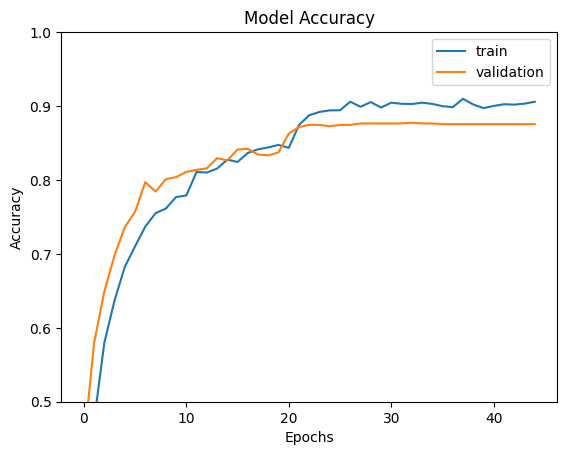

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.ylim([0.5,1])
plt.show()

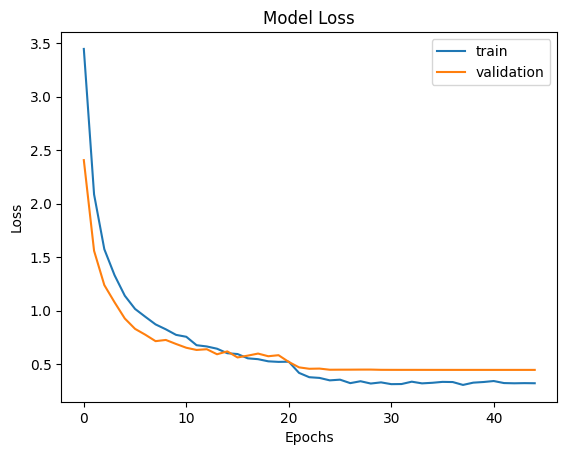

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
#plt.ylim(0.0,)
plt.show()

This model demonstrates an accuracy of ~84% on the test set.

In [32]:
pred = model.evaluate(test_data)
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

32/32 [==============================] - 2s 60ms/step - loss: 0.5545 - accuracy: 0.8363
Loss = 0.5545036792755127
Test Accuracy = 0.8362745046615601
